**Variational Autoencoder on Poor Sevens**

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd
import numpy as np
import pickle

from IPython.display import display, clear_output
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from math import ceil
from IPython.display import Audio
from scipy.io import wavfile
import math
from sklearn.metrics import accuracy_score

%matplotlib inline

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
from google.colab import files
uploaded = files.upload()

Saving hw4_te7.pkl to hw4_te7 (2).pkl
Saving hw4_tr7.pkl to hw4_tr7 (2).pkl


In [0]:
#Loading data and visualizing
with open('hw4_tr7.pkl', 'rb') as f:
    train_data_sevens = pickle.load(f)

with open('hw4_te7.pkl', 'rb') as f:
    test_data_sevens = pickle.load(f)

In [0]:
#Checking size and lengths
len(train_data_sevens)
len(test_data_sevens)

train_data_sevens[0].shape
test_data_sevens[0].shape

6265

1028

(28, 28)

(28, 28)

In [0]:
#Visualization function
def display_function(imgs, name, size):
    n = imgs.shape[0]
    cols = 10
    rows = ceil(n / cols)
    plt.figure(figsize=(1.7 * cols, 2.2 * rows))
    plt.suptitle(name)
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        display_mini(ax, imgs[i,:], size)
        
def display_mini(ax, img, size):
    plt.imshow(img.reshape(size), cmap='Greys_r')
    plt.xticks(())
    plt.yticks(())

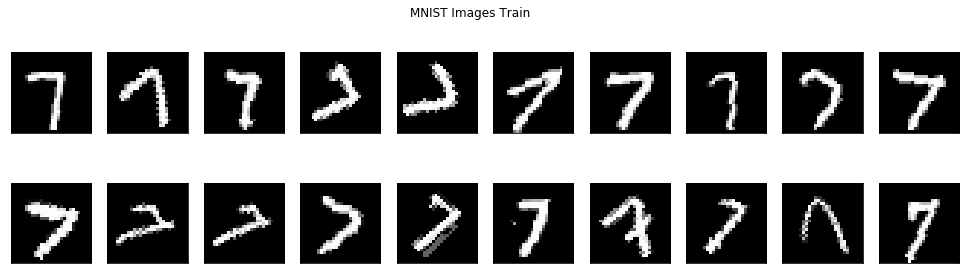

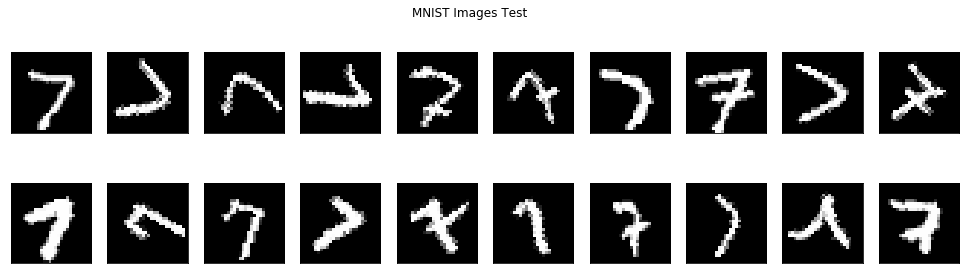

In [0]:
display_function(train_data_sevens[:20], "MNIST Images Train", (28,28))
display_function(test_data_sevens[:20], "MNIST Images Test", (28,28))

In [0]:
#Designing Variational Autoencoder

X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='y')
y_flat = tf.reshape(y, shape=[-1, 28 * 28])
dropout_var = tf.placeholder(dtype=tf.float32, shape=(), name='dropout_var')

decoder_channels = 1
n_latent = 4
decoder_inputs = 4

In [0]:
#Defining activation function

def leaky_relu(x, a=0.4):
  return tf.maximum(x, tf.multiply(x, a))

In [0]:
#Encoder architecture

def vae_encoder(X, dp):
  X_vae = tf.reshape(X, shape=[-1, 28, 28, 1])
  vae = tf.layers.conv2d(X_vae, filters=64, kernel_size=4, strides=2, padding='same', activation=leaky_relu)
  vae = tf.nn.dropout(vae, dp)
  vae = tf.layers.conv2d(vae, filters=64, kernel_size=4, strides=2, padding='same', activation=leaky_relu)
  vae = tf.nn.dropout(vae, dp)
  vae = tf.layers.conv2d(vae, filters=64, kernel_size=4, strides=1, padding='same', activation=leaky_relu)
  vae = tf.nn.dropout(vae, dp)
  vae = tf.contrib.layers.flatten(vae)
  mean_vae = tf.layers.dense(vae, units=n_latent)
  sd_vae = 0.5 * tf.layers.dense(vae, units=n_latent)            
  epsilon_vae = tf.random_normal(tf.stack([tf.shape(vae)[0], n_latent])) 
  z_vae  = mean_vae + tf.multiply(epsilon_vae, tf.exp(sd_vae))
        
  return z_vae, mean_vae, sd_vae

In [0]:
#Decoder architecture

def vae_decoder(z, dp):
  vae_dec = tf.layers.dense(z, units=decoder_inputs, activation=leaky_relu)
  vae_dec = tf.layers.dense(vae_dec, units=decoder_inputs * 2 + 1, activation=leaky_relu)
  vae_dec = tf.reshape(vae_dec, [-1,3,3,1])
  vae_dec = tf.layers.conv2d_transpose(vae_dec, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
  vae_dec = tf.nn.dropout(vae_dec, dp)
  vae_dec = tf.layers.conv2d_transpose(vae_dec, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
  vae_dec = tf.nn.dropout(vae_dec, dp)
  vae_dec = tf.layers.conv2d_transpose(vae_dec, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)      
  vae_dec = tf.contrib.layers.flatten(vae_dec)
  vae_dec = tf.layers.dense(vae_dec, units=28*28, activation=tf.nn.sigmoid)
  img_vae = tf.reshape(vae_dec, shape=[-1, 28, 28])
  return img_vae

In [0]:
#Outputs, loss and optimization

z_vae, mean_vae, sd_vae = vae_encoder(X, dropout_var)
img_vae = vae_decoder(z_vae, dropout_var)

unreshaped_img = tf.reshape(img_vae, [-1, 28*28])
img_vae_loss = tf.reduce_sum(tf.squared_difference(unreshaped_img, y_flat), 1)
latent_vae_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd_vae - tf.square(mean_vae) - tf.exp(2.0 * sd_vae), 1)
loss_vae = tf.reduce_mean(img_vae_loss + latent_vae_loss)
optimizer_vae = tf.train.AdamOptimizer(0.0005).minimize(loss_vae)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use tf.cast instead.


In [0]:
#Running vae on batches for training data

init = tf.global_variables_initializer()

batch_size = 50
max_epochs = 10000
step = 200

sess = tf.Session()
sess.run(init)

for epoch in range(max_epochs):
    random = np.arange(0, 6265, 50)
    for i in range(len(random)):
      start = int(random[i])
      end = int(start + batch_size) 
      data = [np.reshape(b, [28, 28]) for b in train_data_sevens[start:end]]
      sess.run(optimizer_vae, feed_dict = {X: data, y: data, dropout_var: 0.8})
        
    if (epoch +1) % step == 0:
        loss, img, mean_v, sigma_v = sess.run([loss_vae, img_vae, mean_vae, sd_vae], feed_dict = {X: data, y: data, dropout_var: 1.0})
        print("Epoch: %03d/%03d loss: %.9f" % (epoch, max_epochs, loss))

Epoch: 199/10000 loss: 20.680398941
Epoch: 399/10000 loss: 18.671792984
Epoch: 599/10000 loss: 19.158170700
Epoch: 799/10000 loss: 18.853357315
Epoch: 999/10000 loss: 18.427501678
Epoch: 1199/10000 loss: 17.449609756
Epoch: 1399/10000 loss: 18.295019150
Epoch: 1599/10000 loss: 17.848543167
Epoch: 1799/10000 loss: 17.008108139
Epoch: 1999/10000 loss: 16.193155289
Epoch: 2199/10000 loss: 16.135671616
Epoch: 2399/10000 loss: 16.365785599
Epoch: 2599/10000 loss: 17.262632370
Epoch: 2799/10000 loss: 16.515390396
Epoch: 2999/10000 loss: 16.478330612
Epoch: 3199/10000 loss: 16.535827637
Epoch: 3399/10000 loss: 15.970474243
Epoch: 3599/10000 loss: 15.920477867
Epoch: 3799/10000 loss: 15.212088585
Epoch: 3999/10000 loss: 16.171442032
Epoch: 4199/10000 loss: 16.311067581
Epoch: 4399/10000 loss: 17.144279480
Epoch: 4599/10000 loss: 16.396125793
Epoch: 4799/10000 loss: 16.745149612
Epoch: 4999/10000 loss: 15.353311539
Epoch: 5199/10000 loss: 16.291318893
Epoch: 5399/10000 loss: 15.663044930
Epoch:

In [0]:
#Getting the code vectors and checking for each individual code

data = [np.reshape(b, [28, 28]) for b in train_data_sevens]
Z=sess.run(z_vae, feed_dict = {X: data, y: data, dropout_var: 1.0}) #shape : 6265,4

In [0]:
#For the first code vector
first_code_vector = Z[:,0]
single_sample = np.concatenate((np.random.choice(Z[:,1],1),np.random.choice(Z[:,2],1),np.random.choice(Z[:,3],1)))
Z_copy_1 = np.column_stack((first_code_vector,np.array(list([single_sample])*6265)))
print(Z_copy_1)
print(Z_copy_1.shape)

#For the second code vector
second_code_vector = Z[:,1]
single_sample_21 = np.concatenate((np.random.choice(Z[:,2],1),np.random.choice(Z[:,3],1)))
single_sample_22 = np.random.choice(Z[:,0],1)
Z_copy_2 = np.column_stack((np.array(list([single_sample_22])*6265),second_code_vector,np.array(list([single_sample_21])*6265)))
print(Z_copy_2)
print(Z_copy_2.shape)

#For the third code vector
third_code_vector = Z[:,2]
single_sample_31 = np.concatenate((np.random.choice(Z[:,0],1),np.random.choice(Z[:,1],1)))
single_sample_32 = np.random.choice(Z[:,3],1)
Z_copy_3 = np.column_stack((np.array(list([single_sample_31])*6265),third_code_vector,np.array(list([single_sample_32])*6265)))
print(Z_copy_3)
print(Z_copy_3.shape)

#For the fourth code vector
fourth_code_vector = Z[:,3]
single_sample_4 = np.concatenate((np.random.choice(Z[:,0],1),np.random.choice(Z[:,1],1),np.random.choice(Z[:,2],1)))
Z_copy_4 = np.column_stack((np.array(list([single_sample_4])*6265),fourth_code_vector))
print(Z_copy_4)
print(Z_copy_4.shape)

[[-0.3063929   1.9834402   0.5393923   2.1894634 ]
 [ 0.4896686   1.9834402   0.5393923   2.1894634 ]
 [-0.17710331  1.9834402   0.5393923   2.1894634 ]
 ...
 [-1.2417884   1.9834402   0.5393923   2.1894634 ]
 [ 0.6243107   1.9834402   0.5393923   2.1894634 ]
 [-2.0542867   1.9834402   0.5393923   2.1894634 ]]
(6265, 4)
[[-1.1995301  -0.45542586 -0.15046251 -0.44804755]
 [-1.1995301  -1.3714266  -0.15046251 -0.44804755]
 [-1.1995301   0.0069008  -0.15046251 -0.44804755]
 ...
 [-1.1995301  -2.225734   -0.15046251 -0.44804755]
 [-1.1995301  -0.94786096 -0.15046251 -0.44804755]
 [-1.1995301  -1.277796   -0.15046251 -0.44804755]]
(6265, 4)
[[ 0.7339034  -1.1167709   0.8158496   0.77571976]
 [ 0.7339034  -1.1167709  -0.33389038  0.77571976]
 [ 0.7339034  -1.1167709   0.7092713   0.77571976]
 ...
 [ 0.7339034  -1.1167709  -0.04420593  0.77571976]
 [ 0.7339034  -1.1167709  -0.06401575  0.77571976]
 [ 0.7339034  -1.1167709  -0.06942409  0.77571976]]
(6265, 4)
[[ 0.26075363  0.99329823 -0.74533

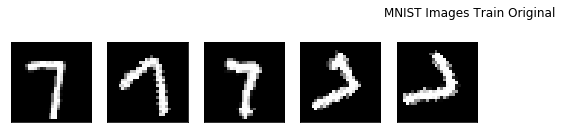

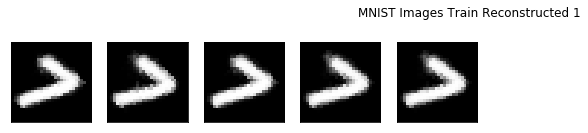

In [0]:
#Checking effect of first code vector

z_values = Z_copy_1
imgs_1 = sess.run(img_vae, feed_dict = {z_vae: z_values, dropout_var: 1.0})
imgs_1 = np.array([np.reshape(imgs_1[i], [28, 28]) for i in range(5)])

#Original images
display_function(train_data_sevens[:5], "MNIST Images Train Original", (28,28))

#Reconstructed images
display_function(imgs_1[:5], "MNIST Images Train Reconstructed 1", (28,28))

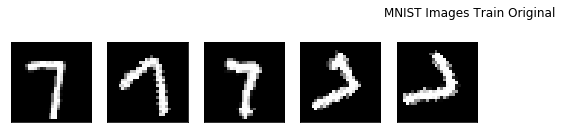

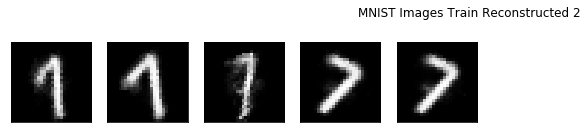

In [0]:
#Checking effect of second code vector

z_values_2 = Z_copy_2
imgs_2 = sess.run(img_vae, feed_dict = {z_vae: z_values_2, dropout_var: 1.0})
imgs_2 = np.array([np.reshape(imgs_2[i], [28, 28]) for i in range(5)])

#Original images
display_function(train_data_sevens[:5], "MNIST Images Train Original", (28,28))

#Reconstructed images
display_function(imgs_2[:5], "MNIST Images Train Reconstructed 2", (28,28))

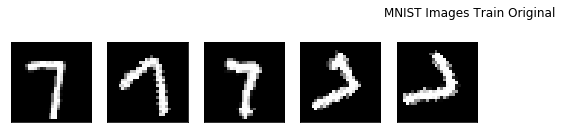

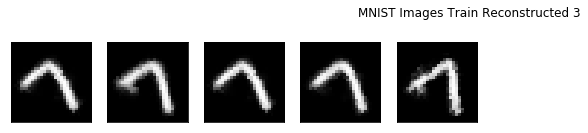

In [0]:
#Checking effect of third code vector

z_values_3 = Z_copy_3
imgs_3 = sess.run(img_vae, feed_dict = {z_vae: z_values_3, dropout_var: 1.0})
imgs_3 = np.array([np.reshape(imgs_3[i], [28, 28]) for i in range(5)])

#Original images
display_function(train_data_sevens[:5], "MNIST Images Train Original", (28,28))

#Reconstructed images
display_function(imgs_3[:5], "MNIST Images Train Reconstructed 3", (28,28))

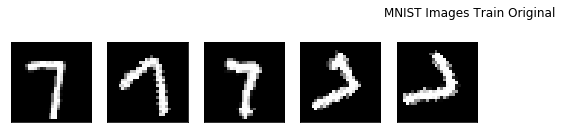

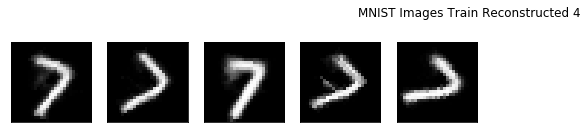

In [0]:
#Checking effect of fourth code vector

z_values_4 = Z_copy_4
imgs_4 = sess.run(img_vae, feed_dict = {z_vae: z_values_4, dropout_var: 1.0})
imgs_4 = np.array([np.reshape(imgs_4[i], [28, 28]) for i in range(5)])

#Original images
display_function(train_data_sevens[:5], "MNIST Images Train Original", (28,28))

#Reconstructed images
display_function(imgs_4[:5], "MNIST Images Train Reconstructed 4", (28,28))

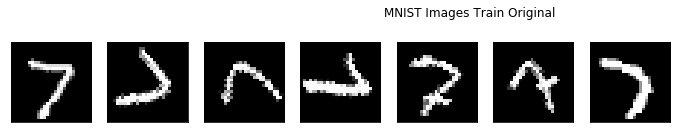

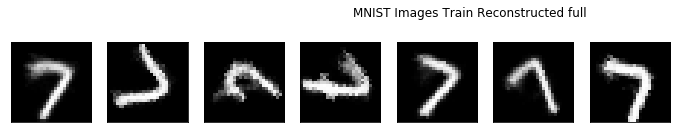

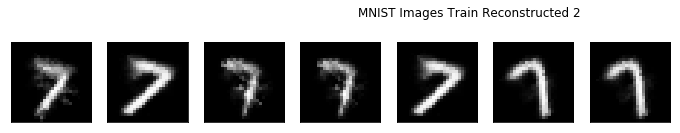

In [0]:
#As per the observations, it seems that the second code vector encodes the primary transformation applied to the poor sevens

#Running the VAE on test data and confirming the effect of the second code vector on the test dataset as well

data_test = [np.reshape(b, [28, 28]) for b in test_data_sevens]
Z_test=sess.run(z_vae, feed_dict = {X: data_test, y: data_test, dropout_var: 1.0})
imgs_vae_test = sess.run(img_vae, feed_dict = {z_vae: Z_test, dropout_var: 1.0})

#Using only effects of the second code vector on test dataset
second_code_vector_test = Z_test[:,1]
single_sample_21_test = np.concatenate((np.random.choice(Z_test[:,2],1),np.random.choice(Z_test[:,3],1)))
single_sample_22_test = np.random.choice(Z_test[:,0],1)
Z_copy_2_test = np.column_stack((np.array(list([single_sample_22_test])*1028),second_code_vector_test,np.array(list([single_sample_21_test])*1028)))

imgs_2_test = sess.run(img_vae, feed_dict = {z_vae: Z_copy_2_test, dropout_var: 1.0})
imgs_2_test = np.array([np.reshape(imgs_2_test[i], [28, 28]) for i in range(7)])

#Original images
#'Train' mentioned in title an error. Refers to 'Test' dataset
display_function(test_data_sevens[:7], "MNIST Images Train Original", (28,28))

#Reconstructed images using complete VAE
#'Train' mentioned in title an error. Refers to 'Test' dataset
display_function(imgs_vae_test[:7], "MNIST Images Train Reconstructed full", (28,28))

#Reconstructed images using second code vector
#'Train' mentioned in title an error. Refers to 'Test' dataset
display_function(imgs_2_test[:7], "MNIST Images Train Reconstructed 2", (28,28))

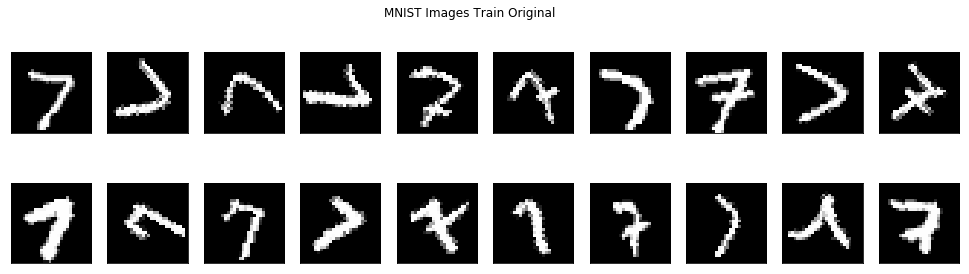

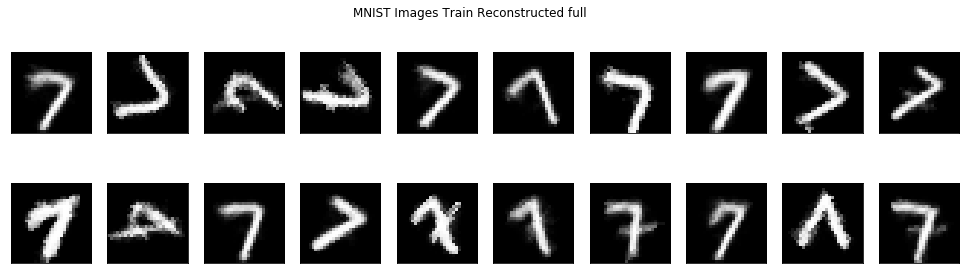

In [0]:
#Original vs Reconstructed Images-full VAE : 20 images on test dataset

#Original images
#'Train' mentioned in title an error. Refers to 'Test' dataset
display_function(test_data_sevens[:20], "MNIST Images Train Original", (28,28))

#Reconstructed images using complete VAE
#'Train' mentioned in title an error. Refers to 'Test' dataset
display_function(imgs_vae_test[:20], "MNIST Images Train Reconstructed full", (28,28))

In [0]:
#Saving reconstructed test data files as pickle object

from google.colab import files
print (imgs_vae_test.shape)

with open('test_sevens_reconstructed.pkl','wb') as f:
  pickle.dump(imgs_vae_test, f)
  
files.download('test_sevens_reconstructed.pkl')

(1028, 28, 28)
